In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

In [3]:
# Dataset
PROJECT_DIR = Path.cwd().parent

parq_path = PROJECT_DIR / "data" / "all_stats.parquet"
df = pd.read_parquet(parq_path)
df.head()


,flight_id,before_after,date_diff,flight_length,label,num_flights_before,volt1_mean,volt1_std,volt1_min,volt1_max,...,NormAc_p25,NormAc_p75,AltMSL_mean,AltMSL_std,AltMSL_min,AltMSL_max,AltMSL_range,AltMSL_p25,AltMSL_p75,AltMSL_rate_mean
0,1,before,-1,4723.0,intake gasket leak/damage,-1,28.780796,4.712894e-02,28.7,29.3,...,-0.01,0.01,2764.796803,1616.009723,835.6,5162.4,4326.8,842.55,4048.9,0.000275
1,2,before,-2,4649.0,intake gasket leak/damage,-2,27.831276,7.633934e-01,25.0,28.2,...,-0.03,0.04,2205.734739,1287.575722,824.1,5261.6,4437.5,887.00,3509.8,-0.001678
2,3,same,0,40.0,intake gasket leak/damage,0,24.900000,3.600403e-15,24.9,24.9,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,before,0,14.0,intake gasket leak/damage,0,25.400000,3.697782e-15,25.4,25.4,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,same,0,683.0,intake gasket leak/damage,0,26.945095,1.271312e+00,24.6,28.1,...,-0.02,0.02,832.528006,5.235779,812.9,846.0,33.1,831.60,835.4,0.031571


In [4]:
# add cluster (target) column
json_path = PROJECT_DIR / "data" / "label_cluster_map.json"
assert json_path.exists()

with json_path.open() as fp:
    label_cluster_map = json.loads(fp.read())

df["cluster"] = df["label"].map(label_cluster_map)

In [8]:
# weighted labels
sort_by = "weight_total_impact"

weighted_labels_path = PROJECT_DIR / "data" / "weighted_labels.csv"
weighted_labels_df = pd.read_csv(weighted_labels_path, index_col=0)
weighted_labels_df.sort_values(by=sort_by, ascending=False).head()
# weighted_labels_df.head()

,label,count,cluster,price_usd,weight_norm,weight_total_impact,risk_factor,weight_risk_factor
7,engine run rough,670,c_24,839.99,0.383613,562793.30,1.4,27185.660955
3,baffle crack/damage/loose/miss,1294,c_4,419.95,0.237344,543415.30,1.3,34472.789022
9,engine failure/fire/time out,643,c_21,839.99,0.382277,540113.57,2.0,37271.599134
10,cylinder compression issue,617,c_13,795.00,0.362015,490515.00,1.7,29574.516259
17,oil cooler need maintenance,312,c_32,1189.00,0.513092,370968.00,1.4,15061.684878


In [11]:
# limit labels and apply filters
num_labels = 5

LABELS = weighted_labels_df.sort_values(by=sort_by, ascending=False)["label"].values[
    :num_labels
]
label_mask = df["label"].isin(LABELS)

# look only at flights before maintenance
before_mask = df["before_after"] == "before"

df_before = df[label_mask & before_mask]

In [12]:
# Choose features for training
features = [
    "AltMSL_max",
    "AltMSL_mean",
    "AltMSL_min",
    "AltMSL_p25",
    "AltMSL_p75",
    "AltMSL_range",
    "AltMSL_rate_mean",
    "AltMSL_std",
    # "E1_CHT1_max",
    # "E1_CHT1_mean",
    # "E1_CHT1_min",
    # "E1_CHT1_p25",
    # "E1_CHT1_p75",
    # "E1_CHT1_std",
    # "E1_CHT2_max",
    # "E1_CHT2_mean",
    # "E1_CHT2_min",
    # "E1_CHT2_p25",
    # "E1_CHT2_p75",
    # "E1_CHT2_std",
    "E1_CHT3_max",
    "E1_CHT3_mean",
    "E1_CHT3_min",
    "E1_CHT3_p25",
    "E1_CHT3_p75",
    "E1_CHT3_std",
    # "E1_CHT4_max",
    # "E1_CHT4_mean",
    # "E1_CHT4_min",
    # "E1_CHT4_p25",
    # "E1_CHT4_p75",
    # "E1_CHT4_std",
    "E1_CHT_max_all",
    "E1_CHT_mean_all",
    "E1_CHT_min_all",
    "E1_CHT_rate_max",
    "E1_CHT_spread_mean",
    "E1_CHT_std_all",
    # "E1_EGT1_max",
    # "E1_EGT1_mean",
    # "E1_EGT1_min",
    # "E1_EGT1_p25",
    # "E1_EGT1_p75",
    # "E1_EGT1_std",
    # "E1_EGT2_max",
    # "E1_EGT2_mean",
    # "E1_EGT2_min",
    # "E1_EGT2_p25",
    # "E1_EGT2_p75",
    # "E1_EGT2_std",
    # "E1_EGT3_max",
    # "E1_EGT3_mean",
    # "E1_EGT3_min",
    # "E1_EGT3_p25",
    # "E1_EGT3_p75",
    # "E1_EGT3_std",
    "E1_EGT4_max",
    "E1_EGT4_mean",
    "E1_EGT4_min",
    "E1_EGT4_p25",
    "E1_EGT4_p75",
    "E1_EGT4_std",
    "E1_EGT_max_all",
    "E1_EGT_mean_all",
    "E1_EGT_min_all",
    "E1_EGT_rate_max",
    "E1_EGT_spread_mean",
    "E1_EGT_std_all",
    "E1_FFlow_max",
    "E1_FFlow_mean",
    "E1_FFlow_min",
    "E1_FFlow_p25",
    "E1_FFlow_p75",
    "E1_FFlow_std",
    "E1_OilP_mean",
    "E1_OilP_min",
    "E1_OilP_p25",
    "E1_OilP_p75",
    "E1_OilP_std",
    "E1_OilT_max",
    "E1_OilT_mean",
    "E1_OilT_min",
    "E1_OilT_p25",
    "E1_OilT_p75",
    "E1_OilT_rate",
    "E1_OilT_std",
    "E1_RPM_max",
    "E1_RPM_mean",
    "E1_RPM_min",
    "E1_RPM_p25",
    "E1_RPM_p75",
    "E1_RPM_std",
    # "FQtyL_consumed",
    # "FQtyL_end",
    # "FQtyL_max",
    # "FQtyL_mean",
    # "FQtyL_min",
    # "FQtyL_p25",
    # "FQtyL_p75",
    # "FQtyL_rate",
    # "FQtyL_start",
    # "FQtyL_std",
    # "FQtyR_consumed",
    # "FQtyR_end",
    # "FQtyR_max",
    # "FQtyR_mean",
    # "FQtyR_min",
    # "FQtyR_p25",
    # "FQtyR_p75",
    # "FQtyR_rate",
    # "FQtyR_start",
    # "FQtyR_std",
    # "IAS_max",
    # "IAS_mean",
    # "IAS_min",
    # "IAS_p25",
    # "IAS_p75",
    # "IAS_rate_mean",
    # "IAS_std",
    # "NormAc_max",
    # "NormAc_mean",
    # "NormAc_min",
    # "NormAc_p25",
    # "NormAc_p75",
    # "NormAc_std",
    # "OAT_max",
    # "OAT_mean",
    # "OAT_min",
    # "OAT_p25",
    # "OAT_p75",
    # "OAT_std",
    # "VSpd_max",
    # "VSpd_mean",
    # "VSpd_min",
    # "VSpd_p25",
    # "VSpd_p75",
    # "VSpd_std",
    "amp1_max",
    "amp1_mean",
    "amp1_min",
    "amp1_p25",
    "amp1_p75",
    "amp1_std",
    "amp2_max",
    "amp2_mean",
    "amp2_min",
    "amp2_p25",
    "amp2_p75",
    "amp2_std",
    # "date_diff",
    # "flight_length",
    "fuel_imbalance_max",
    "fuel_imbalance_mean",
    # "num_flights_before",
    "volt1_max",
    "volt1_mean",
    "volt1_min",
    "volt1_p25",
    "volt1_p75",
    "volt1_std",
    # "volt2_max",
    # "volt2_mean",
    # "volt2_min",
    # "volt2_p25",
    # "volt2_p75",
    # "volt2_std",
]

In [13]:
# Reduce columns only to selected features and dropna
X = df_before[features].dropna()
X.head()

,AltMSL_max,AltMSL_mean,AltMSL_min,AltMSL_p25,AltMSL_p75,AltMSL_range,AltMSL_rate_mean,AltMSL_std,E1_CHT3_max,E1_CHT3_mean,...,amp2_p75,amp2_std,fuel_imbalance_max,fuel_imbalance_mean,volt1_max,volt1_mean,volt1_min,volt1_p25,volt1_p75,volt1_std
5710,13728.8,4270.919238,834.0,1859.650,5517.475,12894.8,-0.000440,3586.439890,378.78,303.767116,...,0.1,0.119385,9.50,2.310710,28.2,28.007167,24.9,28.1,28.2,0.513147
5711,834.3,826.195652,819.6,824.300,827.500,14.7,0.014194,2.212799,372.62,287.034622,...,0.0,0.000000,5.86,1.546940,28.1,26.750564,24.0,25.1,28.0,1.550168
5713,5142.8,3081.316181,834.5,2095.600,4040.700,4308.3,0.002081,1310.127679,346.06,306.239893,...,0.0,0.081896,5.44,2.323237,28.0,27.820548,25.2,27.8,27.9,0.244379
5718,7124.2,5506.888030,833.6,4698.775,7006.800,6290.6,0.004962,2279.306243,394.38,332.112102,...,-0.1,0.072766,7.51,2.731898,28.0,27.794682,24.2,28.0,28.0,0.703671
5719,5319.9,3588.292204,820.1,2685.350,4218.200,4499.8,0.000494,1422.398161,407.89,348.469108,...,0.0,0.096401,8.41,1.780388,28.1,28.074564,25.3,28.1,28.1,0.098699


In [14]:
assert X.shape[1] == len(features)

In [15]:
# y (target)
y = df_before[[*features, "cluster"]].dropna()["cluster"]

In [16]:
assert X.shape[0] == y.shape[0]

In [17]:
# train-test split
test_size = 0.20
random_state = 1350

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state,
    stratify=y,
)

In [18]:
X_train.shape

(1054, 76)

In [19]:
X_train.isna().any().any()

np.False_

In [20]:
X_test.isna().any().any()

np.False_

In [21]:
# Original class distribution
y = df_before["cluster"]
for cluster in y.unique():
    count = y[y == cluster].size
    pct = count / y.size * 100
    print(f"{cluster=}, {count=}, {pct=:.1f}%)")

cluster=np.int64(24), count=311, pct=20.5%)
cluster=np.int64(32), count=123, pct=8.1%)
cluster=np.int64(21), count=236, pct=15.6%)
cluster=np.int64(13), count=302, pct=19.9%)
cluster=np.int64(4), count=545, pct=35.9%)


In [22]:
# Class distribution in train data
for cluster in np.unique(y_train):
    print(cluster)
    count = y_train[y_train == cluster].size
    pct = count / len(y_train) * 100
    print(f"{cluster=}, {count=}, {pct=:.1f}%)")

4
cluster=np.int64(4), count=392, pct=37.2%)
13
cluster=np.int64(13), count=186, pct=17.6%)
21
cluster=np.int64(21), count=162, pct=15.4%)
24
cluster=np.int64(24), count=224, pct=21.3%)
32
cluster=np.int64(32), count=90, pct=8.5%)


In [23]:
# Class distribution in test data
for cluster in np.unique(y_test):
    count = y_test[y_test == cluster].size
    pct = count / len(y_test) * 100
    print(f"{cluster=}, {count=}, {pct=:.1f}%)")

cluster=np.int64(4), count=98, pct=37.1%)
cluster=np.int64(13), count=47, pct=17.8%)
cluster=np.int64(21), count=40, pct=15.2%)
cluster=np.int64(24), count=56, pct=21.2%)
cluster=np.int64(32), count=23, pct=8.7%)


In [24]:
#  train
n_estimators = 500
max_leaf_nodes = 16
class_weight = "balanced"

rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=max_leaf_nodes,
    class_weight=class_weight,
    n_jobs=-1,
)
rf_clf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,16
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# Run Cross-Validation
scoring = "f1_weighted"
cv_results = cross_validate(rf_clf, X_test, y_test, cv=5, scoring=scoring)

scores = cv_results["test_score"]
print(scores)

[0.26316653 0.2961421  0.34489999 0.3632235  0.41334104]


In [27]:
# Make predicitions
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)
y_true = y_test

In [28]:
# Accuracy
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"{balanced_acc=:0.3f}")


balanced_acc=0.355


f1_macro=0.32907516137738535
f1_weighted=0.35174439228209764
f1_per_class=array([0.42767296, 0.45925926, 0.25316456, 0.23076923, 0.2745098 ])


Text(0.5, 1.0, 'F1-Scores')

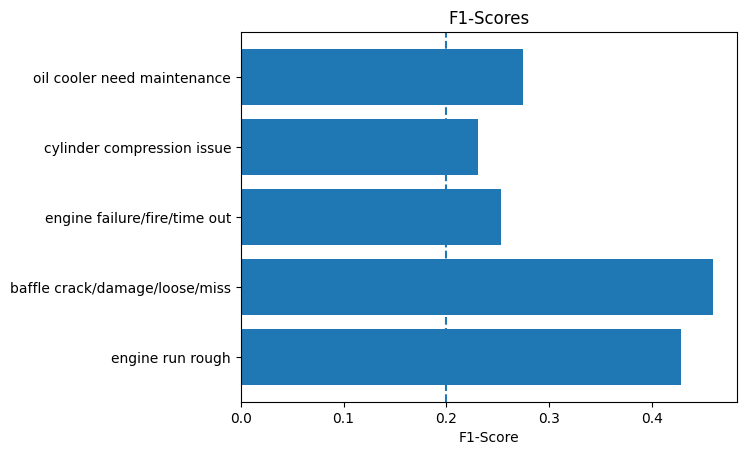

In [29]:
# F1-Scores
f1_macro = f1_score(y_true, y_pred, average="macro")
print(f"{f1_macro=}")

f1_weighted = f1_score(y_true, y_pred, average="weighted")
print(f"{f1_weighted=}")

f1_per_class = f1_score(y_true, y_pred, average=None)
print(f"{f1_per_class=}")

# Plot F1 Scores per class
plt.barh(LABELS, f1_per_class)
plt.axvline(x=1 / len(LABELS), linestyle="--")  # naive baseline
plt.xlabel("F1-Score")
plt.title("F1-Scores")

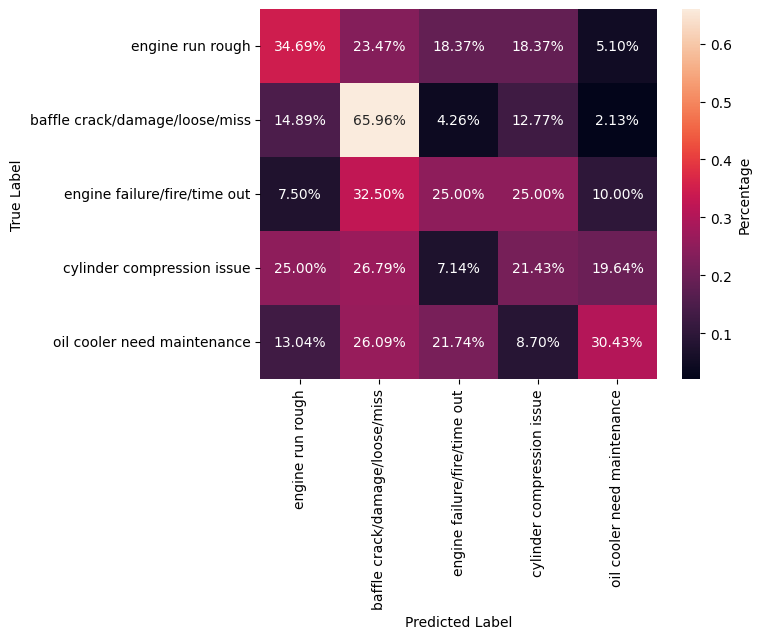

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2%",
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={"label": "Percentage"},
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label");